In [40]:
!pip install --upgrade pip setuptools wheel
!pip install --upgrade tensorflow
!pip install tensorflow==2.x
!pip install --upgrade tensorflow[and-cuda]

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement tensorflow==2.x (from versions: 2.16.0rc0, 2.16.1)
ERROR: No matching distribution found for tensorflow==2.x


Defaulting to user installation because normal site-packages is not writeable
  Using cached nvidia_cublas_cu12-12.3.4.1-py3-none-win_amd64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.3.101-py3-none-win_amd64.whl.metadata (1.6 kB)
  Using cached nvidia_cuda_nvcc_cu12-12.3.107-py3-none-win_amd64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.3.107-py3-none-win_amd64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.3.101-py3-none-win_amd64.whl.metadata (1.5 kB)
  Using cached nvidia_cudnn_cu12-8.9.7.29-py3-none-win_amd64.whl.metadata (1.6 kB)
  Using cached nvidia_cufft_cu12-11.0.12.1-py3-none-win_amd64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.4.107-py3-none-win_amd64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.5.4.101-py3-none-win_amd64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.2.0.103-py3-none-win_amd64.whl.metadata (1.6 kB)
INFO: pip is looking at multiple versions of tensorflow[

ERROR: Cannot install tensorflow[and-cuda]==2.16.1 because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts


In [41]:
# General Imports
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

from sklearn.metrics import confusion_matrix

# Neural Network imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam

# Image augmentation importrs
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import RandomContrast
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomTranslation

# Training Model callbacks
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

# Check if GPU is available
print(f'Tensorflow Version: {tf.__version__}')
if tf.config.list_physical_devices('GPU'):
    print("GPU Available: Yes")
else:
    print("GPU Available: No")

SEED = 111

# Data Visualization updates
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams.update({'font.size': 14})

Tensorflow Version: 2.16.1
GPU Available: No


In [42]:
def get_data_labels(directory, shuffle=True, random_state=0):
    from sklearn.utils import shuffle
    data_path = []
    data_index = []
    label_dict = {label: index for index, label in enumerate(sorted(os.listdir(directory)))}
    
    for label, index in label_dict.items():
        label_dir = os.path.join(directory, label)
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            data_path.append(image_path)
            data_index.append(index)
            
    if shuffle:
        data_path, data_index = shuffle(data_path, data_index, random_state=random_state)
            
    return data_path, data_index

def parse_function(filename, label, image_size, n_channels):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, n_channels)
    image = tf.image.resize(image, image_size)
    return image, label

def get_dataset(paths, labels, image_size, n_channels=1, num_classes=4, batch_size=32):
    path_ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    image_label_ds = path_ds.map(lambda path, label: parse_function(path, label, image_size, n_channels), 
                                 num_parallel_calls=tf.data.AUTOTUNE)
    return image_label_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [43]:
# Getting data labels
USER_PATH = "C:\\Users\\saiva\\Downloads\\archive (3).zip"
train_paths, train_index = get_data_labels("C:\\Users\\saiva\\Downloads\\archive (3)\\Training", random_state=SEED)
test_paths, test_index = get_data_labels("C:\\Users\\saiva\\Downloads\\archive (3)\\Testing", random_state=SEED)

# Printing traing and testing sample sizes
print('Training')
print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_index)}')
print('\nTesting')
print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_index)}')

# Prepare datasets with 4 classes and grayscale
batch_size = 32
image_dim = (168, 168)
train_ds = get_dataset(train_paths, train_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)
test_ds = get_dataset(test_paths, test_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)

# Output to show datasets
print(f"\nTraining dataset: {train_ds}")
print(f"\nTesting dataset: {test_ds}")

# Class mappings
class_mappings = {'Glioma': 0, 'Meninigioma': 1, 'Notumor': 2, 'Pituitary': 3}
inv_class_mappings = {v: k for k, v in class_mappings.items()}
class_names = list(class_mappings.keys())

Training
Number of Paths: 5712
Number of Labels: 5712

Testing
Number of Paths: 1311
Number of Labels: 1311

Training dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 168, 168, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Testing dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 168, 168, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


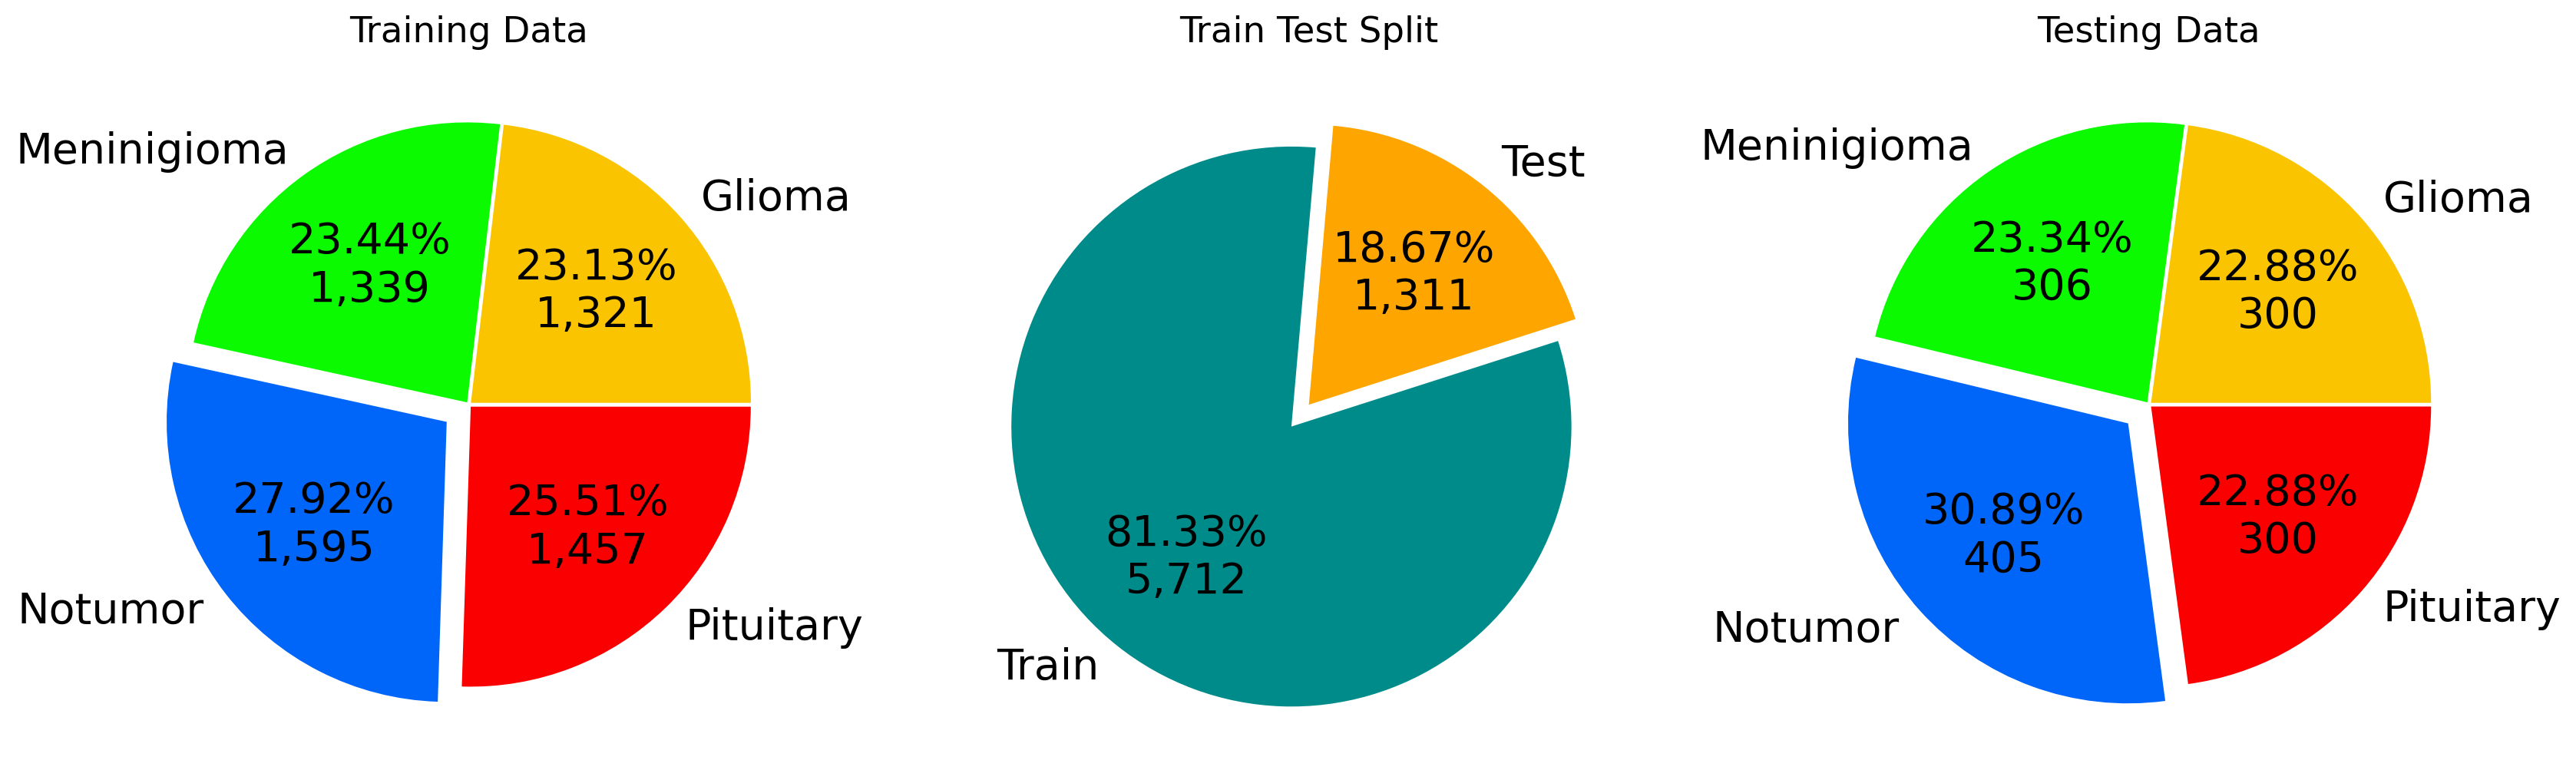

In [44]:
_, ax = plt.subplots(ncols=3, figsize=(20, 14))

# Plotting training data types
class_counts = [len([x for x in train_index if x == label]) for label in set(train_index)]
ax[0].set_title('Training Data')
ax[0].pie(
    class_counts,
    labels=[label for label in class_names],
    colors=['#FAC500','#0BFA00', '#0066FA','#FA0000'], 
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts) / 100),
    explode=(0.01, 0.01, 0.1, 0.01),
    textprops={'fontsize': 20}
)

# Plotting distribution of train test split
ax[1].set_title('Train Test Split')
ax[1].pie(
    [len(train_index), len(test_index)],
    labels=['Train','Test'],
    colors=['darkcyan', 'orange'], 
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum([len(train_index), len(test_index)]) / 100),
    explode=(0.1, 0),
    startangle=85,
    textprops={'fontsize': 20}
)

# Plotting testing data types
class_counts = [len([x for x in test_index if x == label]) for label in set(test_index)]
ax[2].set_title('Testing Data')
ax[2].pie(
    class_counts,
    labels=[label for label in class_names],
    colors=['#FAC500', '#0BFA00', '#0066FA', '#FA0000'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts) / 100),
    explode=(0.01, 0.01, 0.1, 0.01),
    textprops={'fontsize': 20} 
)

plt.show()

In [45]:
# Function to display a list of images based on the given index
def show_images(paths, label_paths, class_mappings, index_list=range(10), im_size=250, figsize=(12, 8)):
    
    num_images = len(index_list)
    num_rows = (num_images + 3) // 4
    index_to_class = {v: k for k, v in class_mappings.items()}
    _, ax = plt.subplots(nrows=num_rows, ncols=4, figsize=figsize)
    ax = ax.flatten()
    
    for i, index in enumerate(index_list):
        if i >= num_images:
            break
        image = load_img(paths[index], target_size=(im_size, im_size), color_mode='grayscale')
        ax[i].imshow(image, cmap='Greys_r')
        class_name = index_to_class[label_paths[index]]
        ax[i].set_title(f'{index}: {class_name}')
        ax[i].axis('off')
        
    plt.tight_layout()
    plt.show()

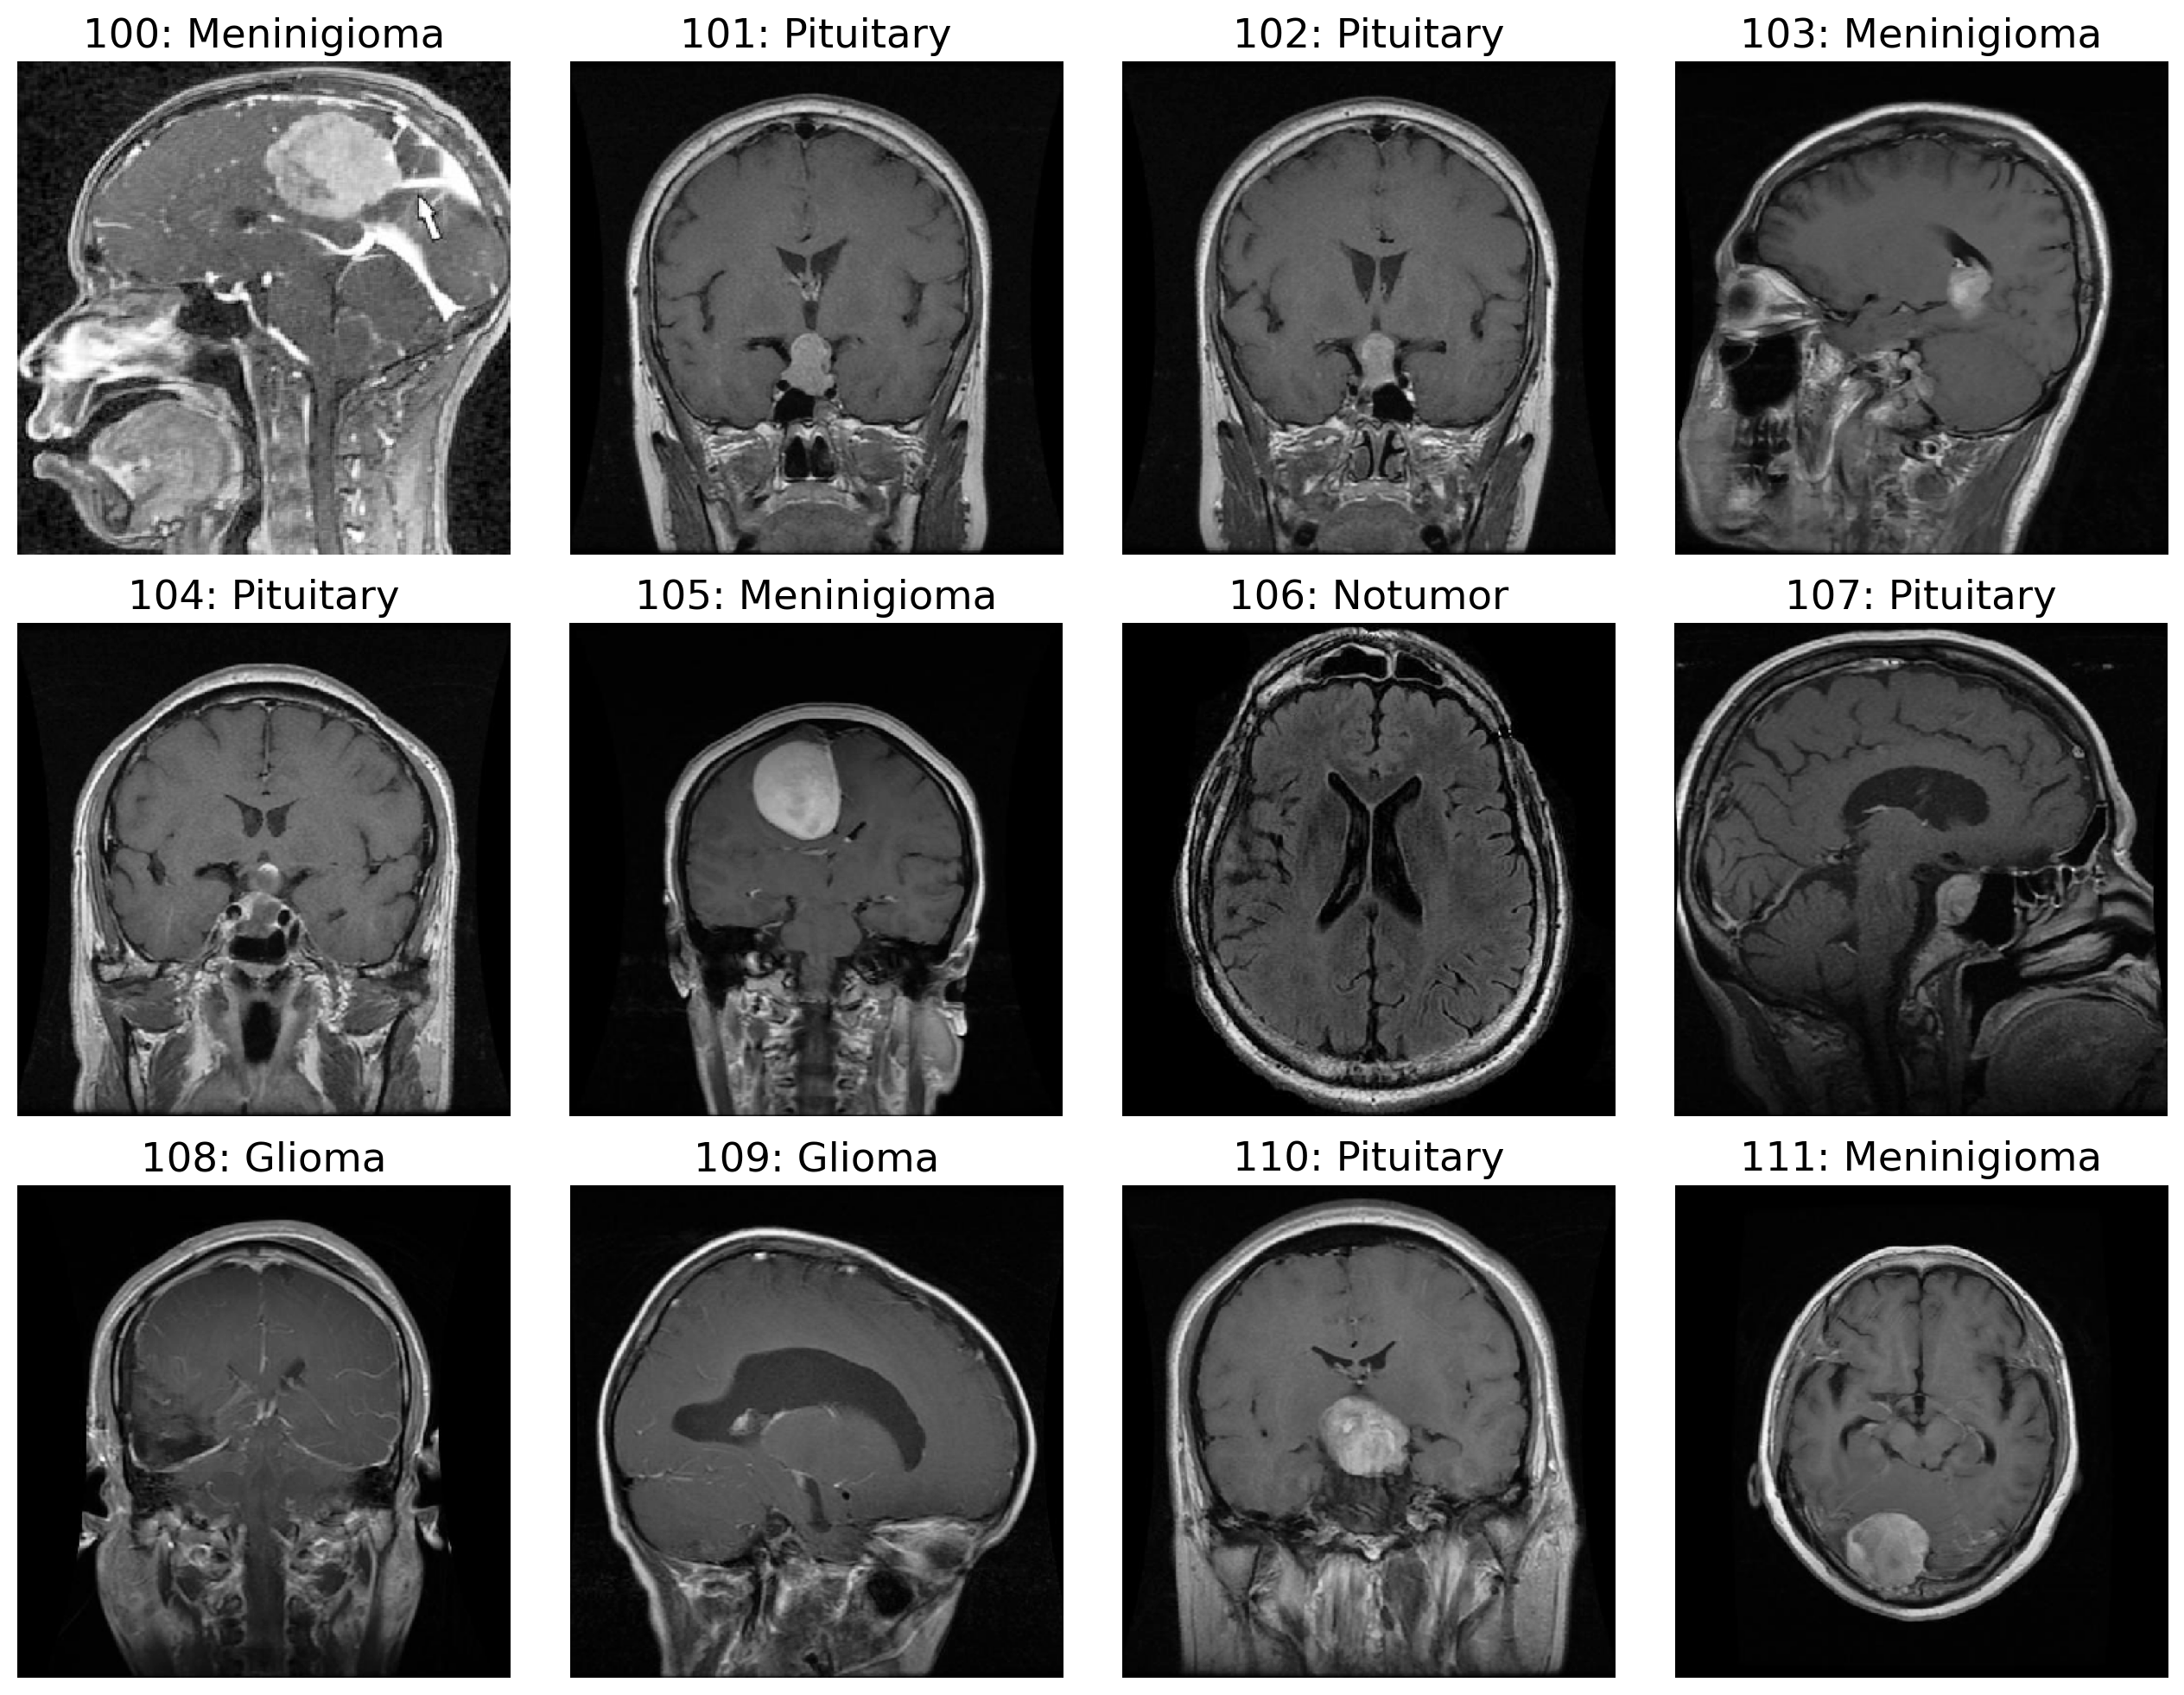

In [46]:
# Four different classes images from different angles
show_images(train_paths, train_index, class_mappings, im_size=350, figsize=(13,10),
            index_list=range(100, 112))

In [47]:
# Dta augmentation sequential model
data_augmentation = Sequential([
    # RandomFlip("horizontal_and_vertical"),
    RandomFlip("horizontal"),
    RandomRotation(0.02, fill_mode='constant'),
    RandomContrast(0.1),
    RandomZoom(height_factor=0.01, width_factor=0.05),
    RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),
])

# Training augmentation and nornalization
def preprocess_train(image, label):
    # Apply data augmentation and Normalize
    image = data_augmentation(image) / 255.0
    return image, label

# For test dataset only appying normalization
def preprocess_test(image, label):
    return image / 255.0, label

# Apply transformation to training and testing datasets
train_ds_preprocessed = train_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

In [48]:
# Function to display augmented images
def plot_augmented_images(dataset, shape, class_mappings, figsize=(15, 6)):
    plt.figure(figsize=figsize)
    index_to_class = {v: k for k, v in class_mappings.items()}
    for images, label in dataset.take(1):
        i = 0
        for i in range(shape[0]*shape[1]):
            ax = plt.subplot(shape[0], shape[1], i + 1)
            plt.imshow(images[i].numpy().squeeze(), cmap='gray')
            plt.title(index_to_class[label.numpy()[i]])
            plt.axis("off")
            i += 1
            
    plt.tight_layout()
    plt.show()

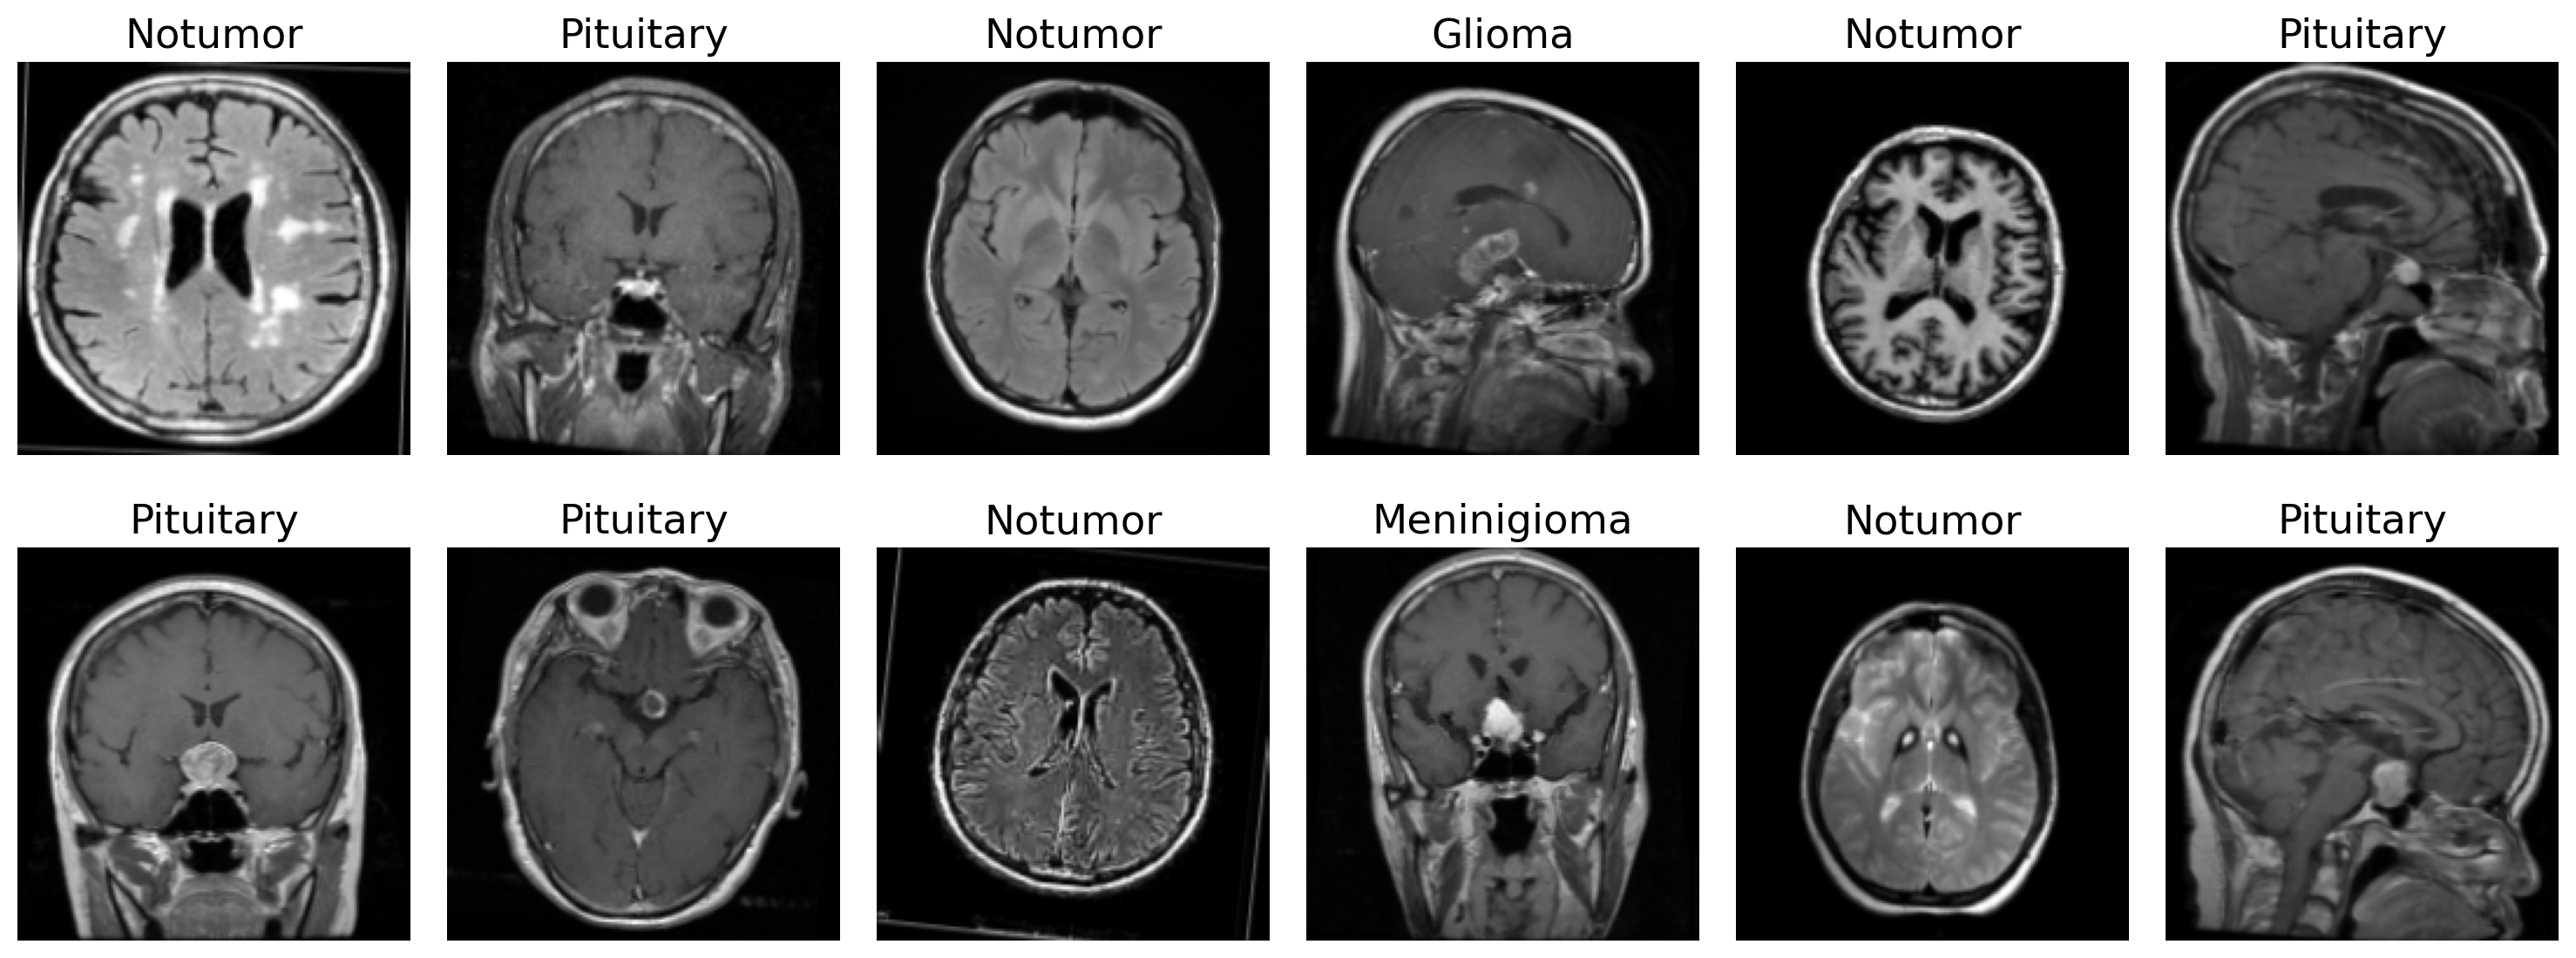

In [49]:
# Displaying augmented images
plot_augmented_images(train_ds_preprocessed, shape=(2, 6), class_mappings=class_mappings)

In [50]:
# Classes and Image shape: height, width, grayscale
num_classes = len(class_mappings.keys())
image_shape = (image_dim[0], image_dim[1], 1) 

# Training epochs and batch size
epochs = 50
print(f'Number of Classes: {num_classes}')
print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')

def encode_labels(image, label): 
    return image, tf.one_hot(label, depth=num_classes)

train_ds_preprocessed = train_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)

Number of Classes: 4
Image shape: (168, 168, 1)
Epochs: 50
Batch size: 32


In [51]:
# Muilding model
model = Sequential([
    Input(shape=image_shape),
    
    Conv2D(32, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 2
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 3
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional layer 4
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),

    # Full connect layers
    Dense(512, activation="relu"),
    Dropout(0.05, seed=SEED),
    Dense(num_classes, activation="softmax")
])

model.summary()

optimizer = Adam(learning_rate=0.001, beta_1=0.869, beta_2=0.995)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 164, 164, 32)   │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 50, 50, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 13, 13, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 3, 3, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 513,668 (1.96 MB)

 Trainable params: 513,668 (1.96 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
# Callbacks
model_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=10, verbose=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=4, verbose=False)
model_mc = ModelCheckpoint('model.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=False)

# Training the model
history = model.fit(
    train_ds_preprocessed,
    epochs=epochs,
    validation_data=test_ds_preprocessed,
    callbacks=[model_es, model_rlr, model_mc],
    verbose=True
)

Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 50s 275ms/step - accuracy: 0.4955 - loss: 1.0949 - val_accuracy: 0.7063 - val_loss: 0.7255 - learning_rate: 0.0010
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 76s 242ms/step - accuracy: 0.7915 - loss: 0.5604 - val_accuracy: 0.7925 - val_loss: 0.4865 - learning_rate: 0.0010
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 46s 257ms/step - accuracy: 0.8459 - loss: 0.3924 - val_accuracy: 0.8268 - val_loss: 0.4407 - learning_rate: 0.0010
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 77s 231ms/step - accuracy: 0.8935 - loss: 0.2744 - val_accuracy: 0.9024 - val_loss: 0.2947 - learning_rate: 0.0010
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 44s 247ms/step - accuracy: 0.9245 - loss: 0.1926 - val_accuracy: 0.9184 - val_loss: 0.2658 - learning_rate: 0.0010
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 42s 235ms/step - accuracy: 0.9374 - loss: 0.1772 - val_accuracy: 0.8467 - val_loss: 0.4603 - learning_rate: 0.0010
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 43s 236ms/step - accuracy: 0.9

In [53]:
# Loading saved model
model = load_model('model.keras')

# Evaluate model and test data accuracy
test_loss, test_acc = model.evaluate(test_ds_preprocessed)
print(f"Test accuracy: {test_acc*100:0.2f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9892 - loss: 0.0568
Test accuracy: 99.01%


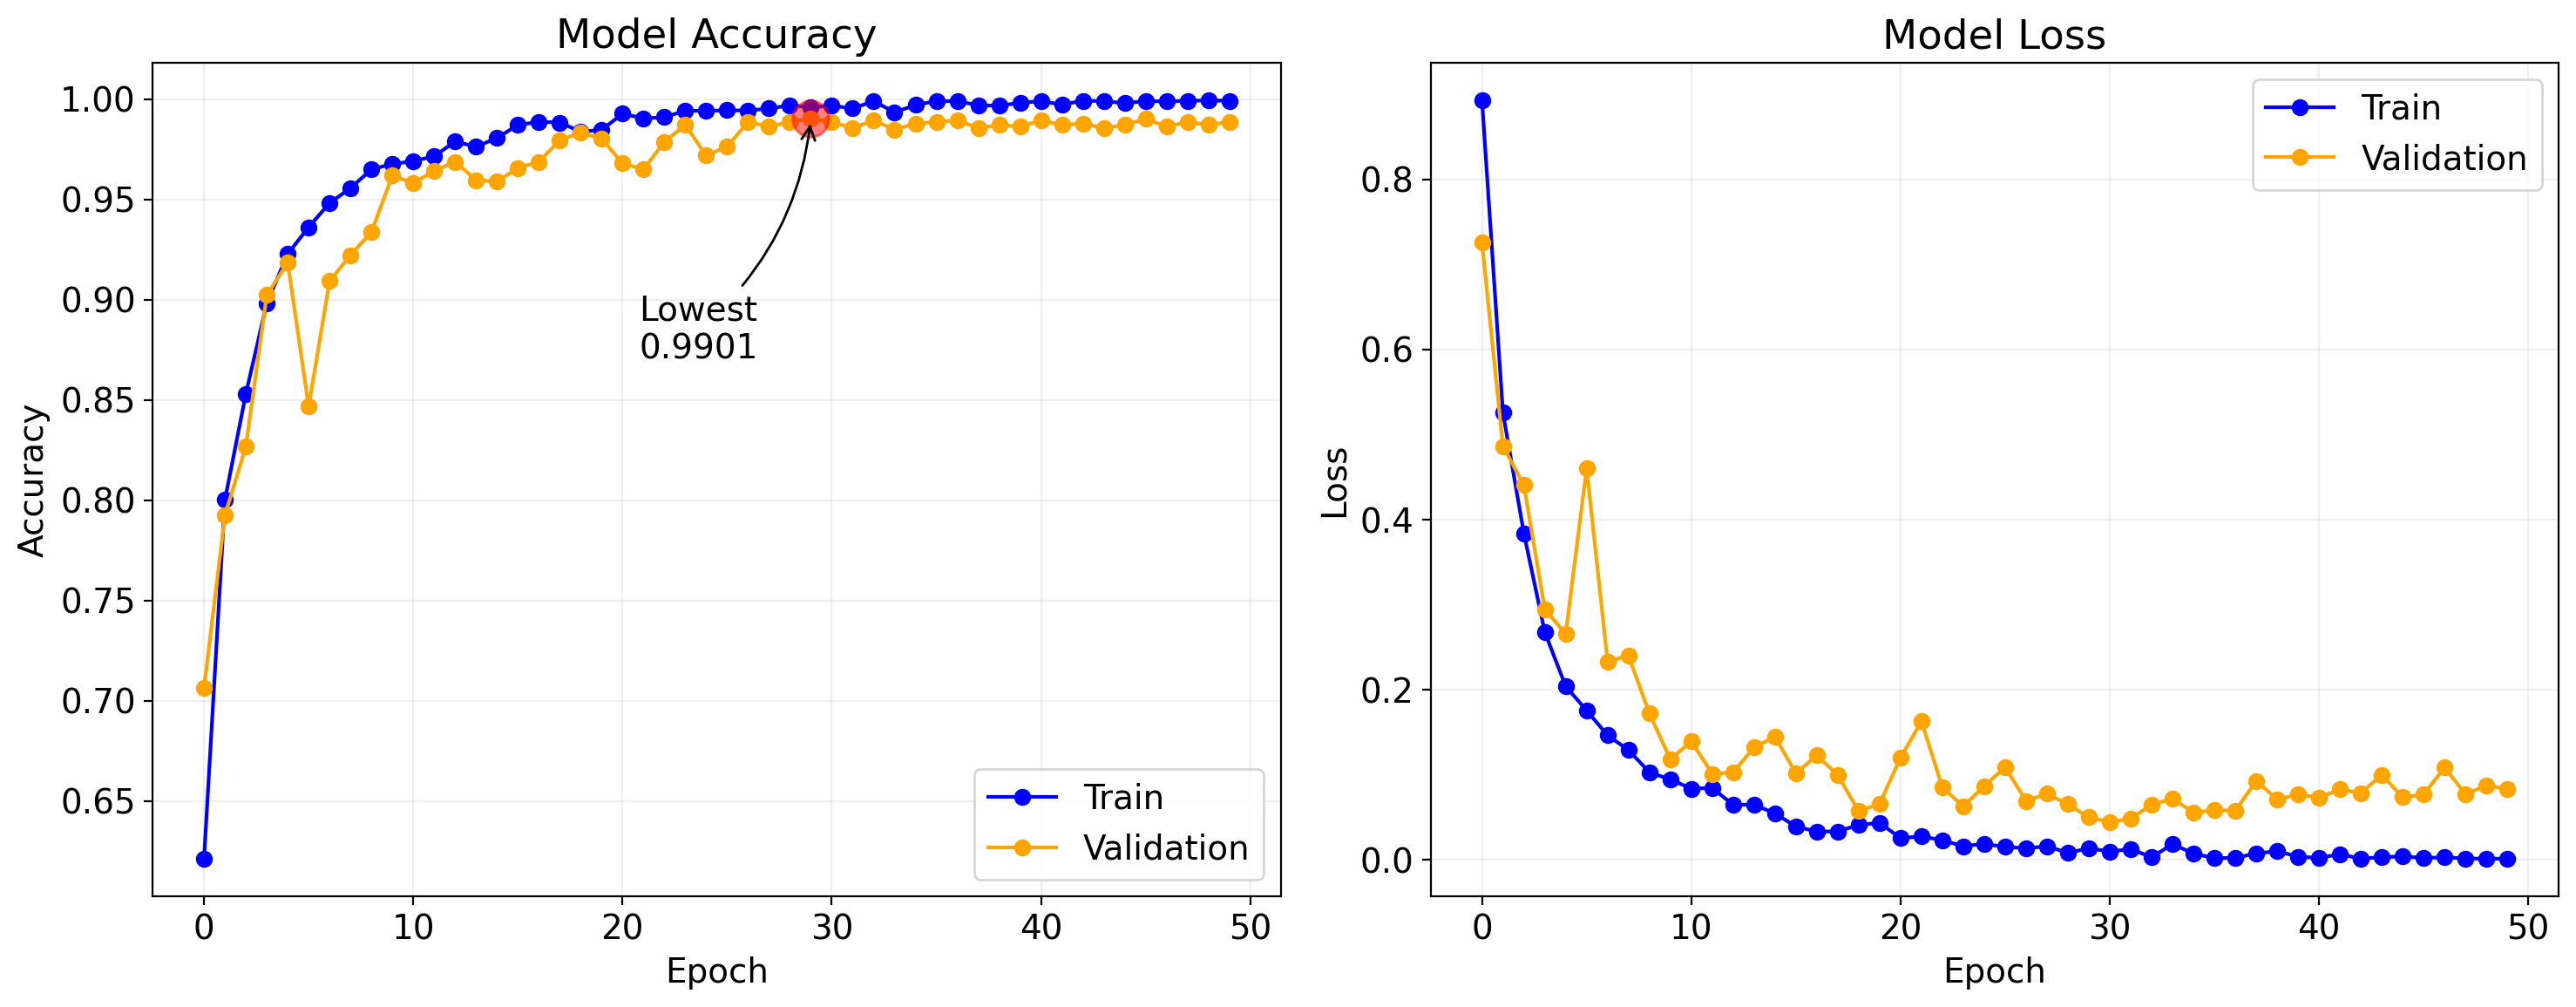

In [55]:
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plotting training and validation accuracy over epochs
ax[0].plot(history.history['accuracy'], marker='o', linestyle='-', color='blue')
ax[0].plot(history.history['val_accuracy'], marker='o', linestyle='-', color='orange')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'], loc='lower right')
ax[0].grid(alpha=0.2)

# Plotting training and validation loss over epochs
ax[1].plot(history.history['loss'], marker='o', linestyle='-', color='blue')
ax[1].plot(history.history['val_loss'], marker='o', linestyle='-', color='orange')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'], loc='upper right')
ax[1].grid(alpha=0.2)

# Highlight lowest validation accuracy
min_val_acc_epoch = np.argmax(history.history['val_accuracy'])
min_val_acc = np.max(history.history['val_accuracy'])
ax[0].plot(min_val_acc_epoch, min_val_acc, 'ro', markersize=15, alpha=0.5)
ax[0].annotate(f'Lowest\n{min_val_acc:.4f}', xy=(min_val_acc_epoch, min_val_acc), 
               xytext=(min_val_acc_epoch - 100, min_val_acc - 100), textcoords='offset points',
               arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

plt.tight_layout()
plt.show()


In [58]:
# Using test_ds_preprocessed and model for true and preductions
true_labels = []
predicted_labels = []

# Iterate over dataset to collect predictions and true labels
for images, labels in test_ds_preprocessed.unbatch():  # Unbatch to get sample-wise prediction
    # Store true labels
    true_label = np.argmax(labels.numpy())  # Convert one-hot to index
    true_labels.append(true_label)
    
    # Get model prediction
    pred = model.predict(tf.expand_dims(images, 0), verbose=False)  # Predict expects batch dimension
    predicted_label = np.argmax(pred)
    predicted_labels.append(predicted_label)

In [60]:
def plot_confusion_matrix(true_labels, predicted_labels, class_mappings, metrics=False, cmap='Blues'):
    # Compute  confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, normalize=None)  # You can use normalize='true' for normalized CM
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    # Mapping of indices to class names in class_mappings
    plt.xticks(ticks=np.arange(num_classes) + 0.5, labels=class_mappings.keys(), ha='center')
    plt.yticks(ticks=np.arange(num_classes) + 0.5, labels=class_mappings.keys(), va='center')
    plt.show()

    if metrics:
        # Precision, Recall, and F1-Score for each class & Overall accuracy
        precision = np.diag(cm) / np.sum(cm, axis=0)
        recall = np.diag(cm) / np.sum(cm, axis=1)
        f1_scores = 2 * precision * recall / (precision + recall)
        accuracy = np.sum(np.diag(cm)) / np.sum(cm)

        print("Class-wise metrics:")
        for i in range(len(class_mappings)):
            class_name = list(class_mappings.keys())[i]
            print(f"\033[94mClass: {class_name}\033[0m")
            print(f"Precision: {precision[i]:.4f}")
            print(f"Recall: {recall[i]:.4f}")
            print(f"F1-Score: {f1_scores[i]:.4f}\n")

        print(f"\033[92mOverall Accuracy: {accuracy:.4f}\033[0m")

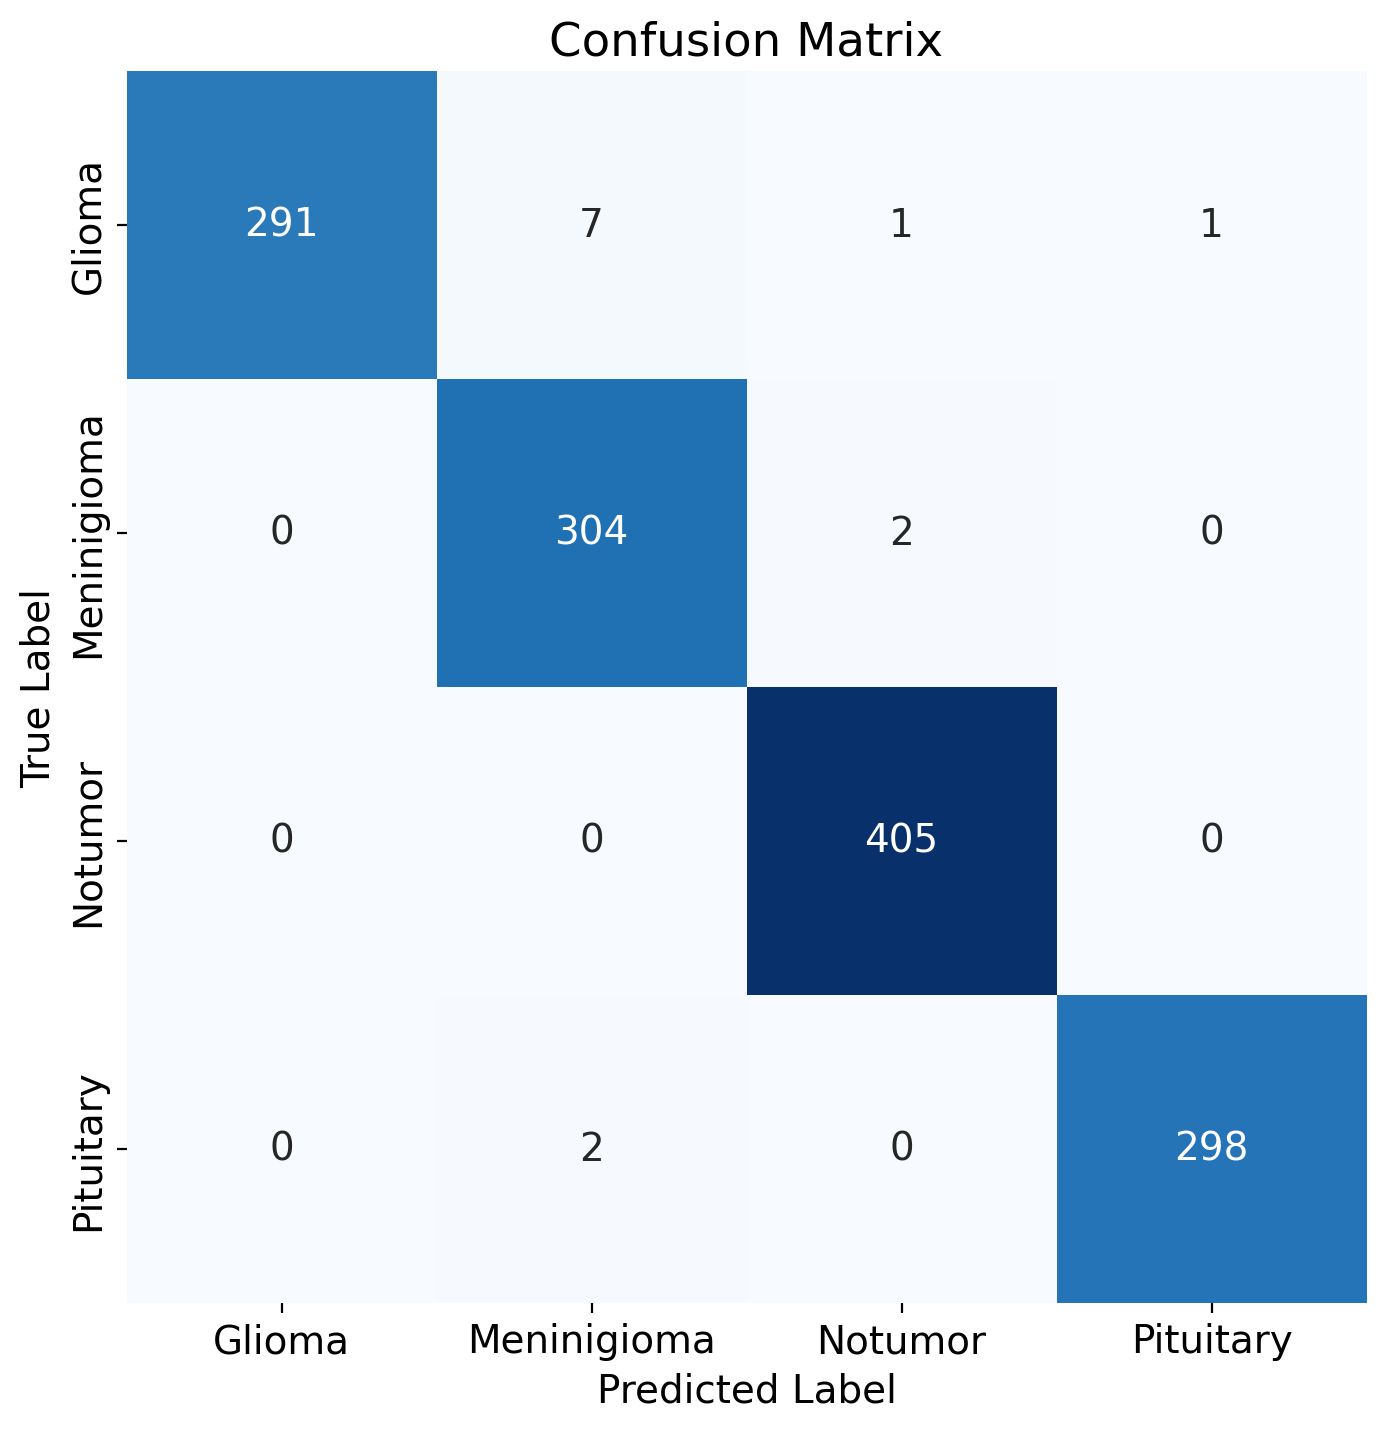

Class-wise metrics:
Class: Glioma
Precision: 1.0000
Recall: 0.9700
F1-Score: 0.9848

Class: Meninigioma
Precision: 0.9712
Recall: 0.9935
F1-Score: 0.9822

Class: Notumor
Precision: 0.9926
Recall: 1.0000
F1-Score: 0.9963

Class: Pituitary
Precision: 0.9967
Recall: 0.9933
F1-Score: 0.9950

Overall Accuracy: 0.9901


In [61]:
# Confusion matrix and calculated netrics from model predictions
plot_confusion_matrix(true_labels,
                      predicted_labels, 
                      class_mappings,
                      metrics=True)

In [62]:
def plot_sample_predictions(model, dataset, index_to_class, num_samples=9, figsize=(13, 12)):
    plt.figure(figsize=figsize)
    num_rows = num_cols = int(np.sqrt(num_samples))
    
    iterator = iter(dataset.unbatch())

    for i in range(1, num_samples + 1):
        image, true_label = next(iterator)
        image_batch = tf.expand_dims(image, 0)
        predictions = model.predict(image_batch, verbose=False)
        predicted_label = np.argmax(predictions, axis=1)[0]

        true_class_index = np.argmax(true_label.numpy())
        true_class = index_to_class[true_class_index]
        predicted_class = index_to_class[predicted_label]

        # Determine title color based on prediction accuracy
        title_color = 'green' if true_class_index == predicted_label else 'red'

        plt.subplot(num_rows, num_cols, i)
        plt.imshow(image.numpy().squeeze(), cmap='gray')
        plt.title(f"True: {true_class}\nPred: {predicted_class}", color=title_color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

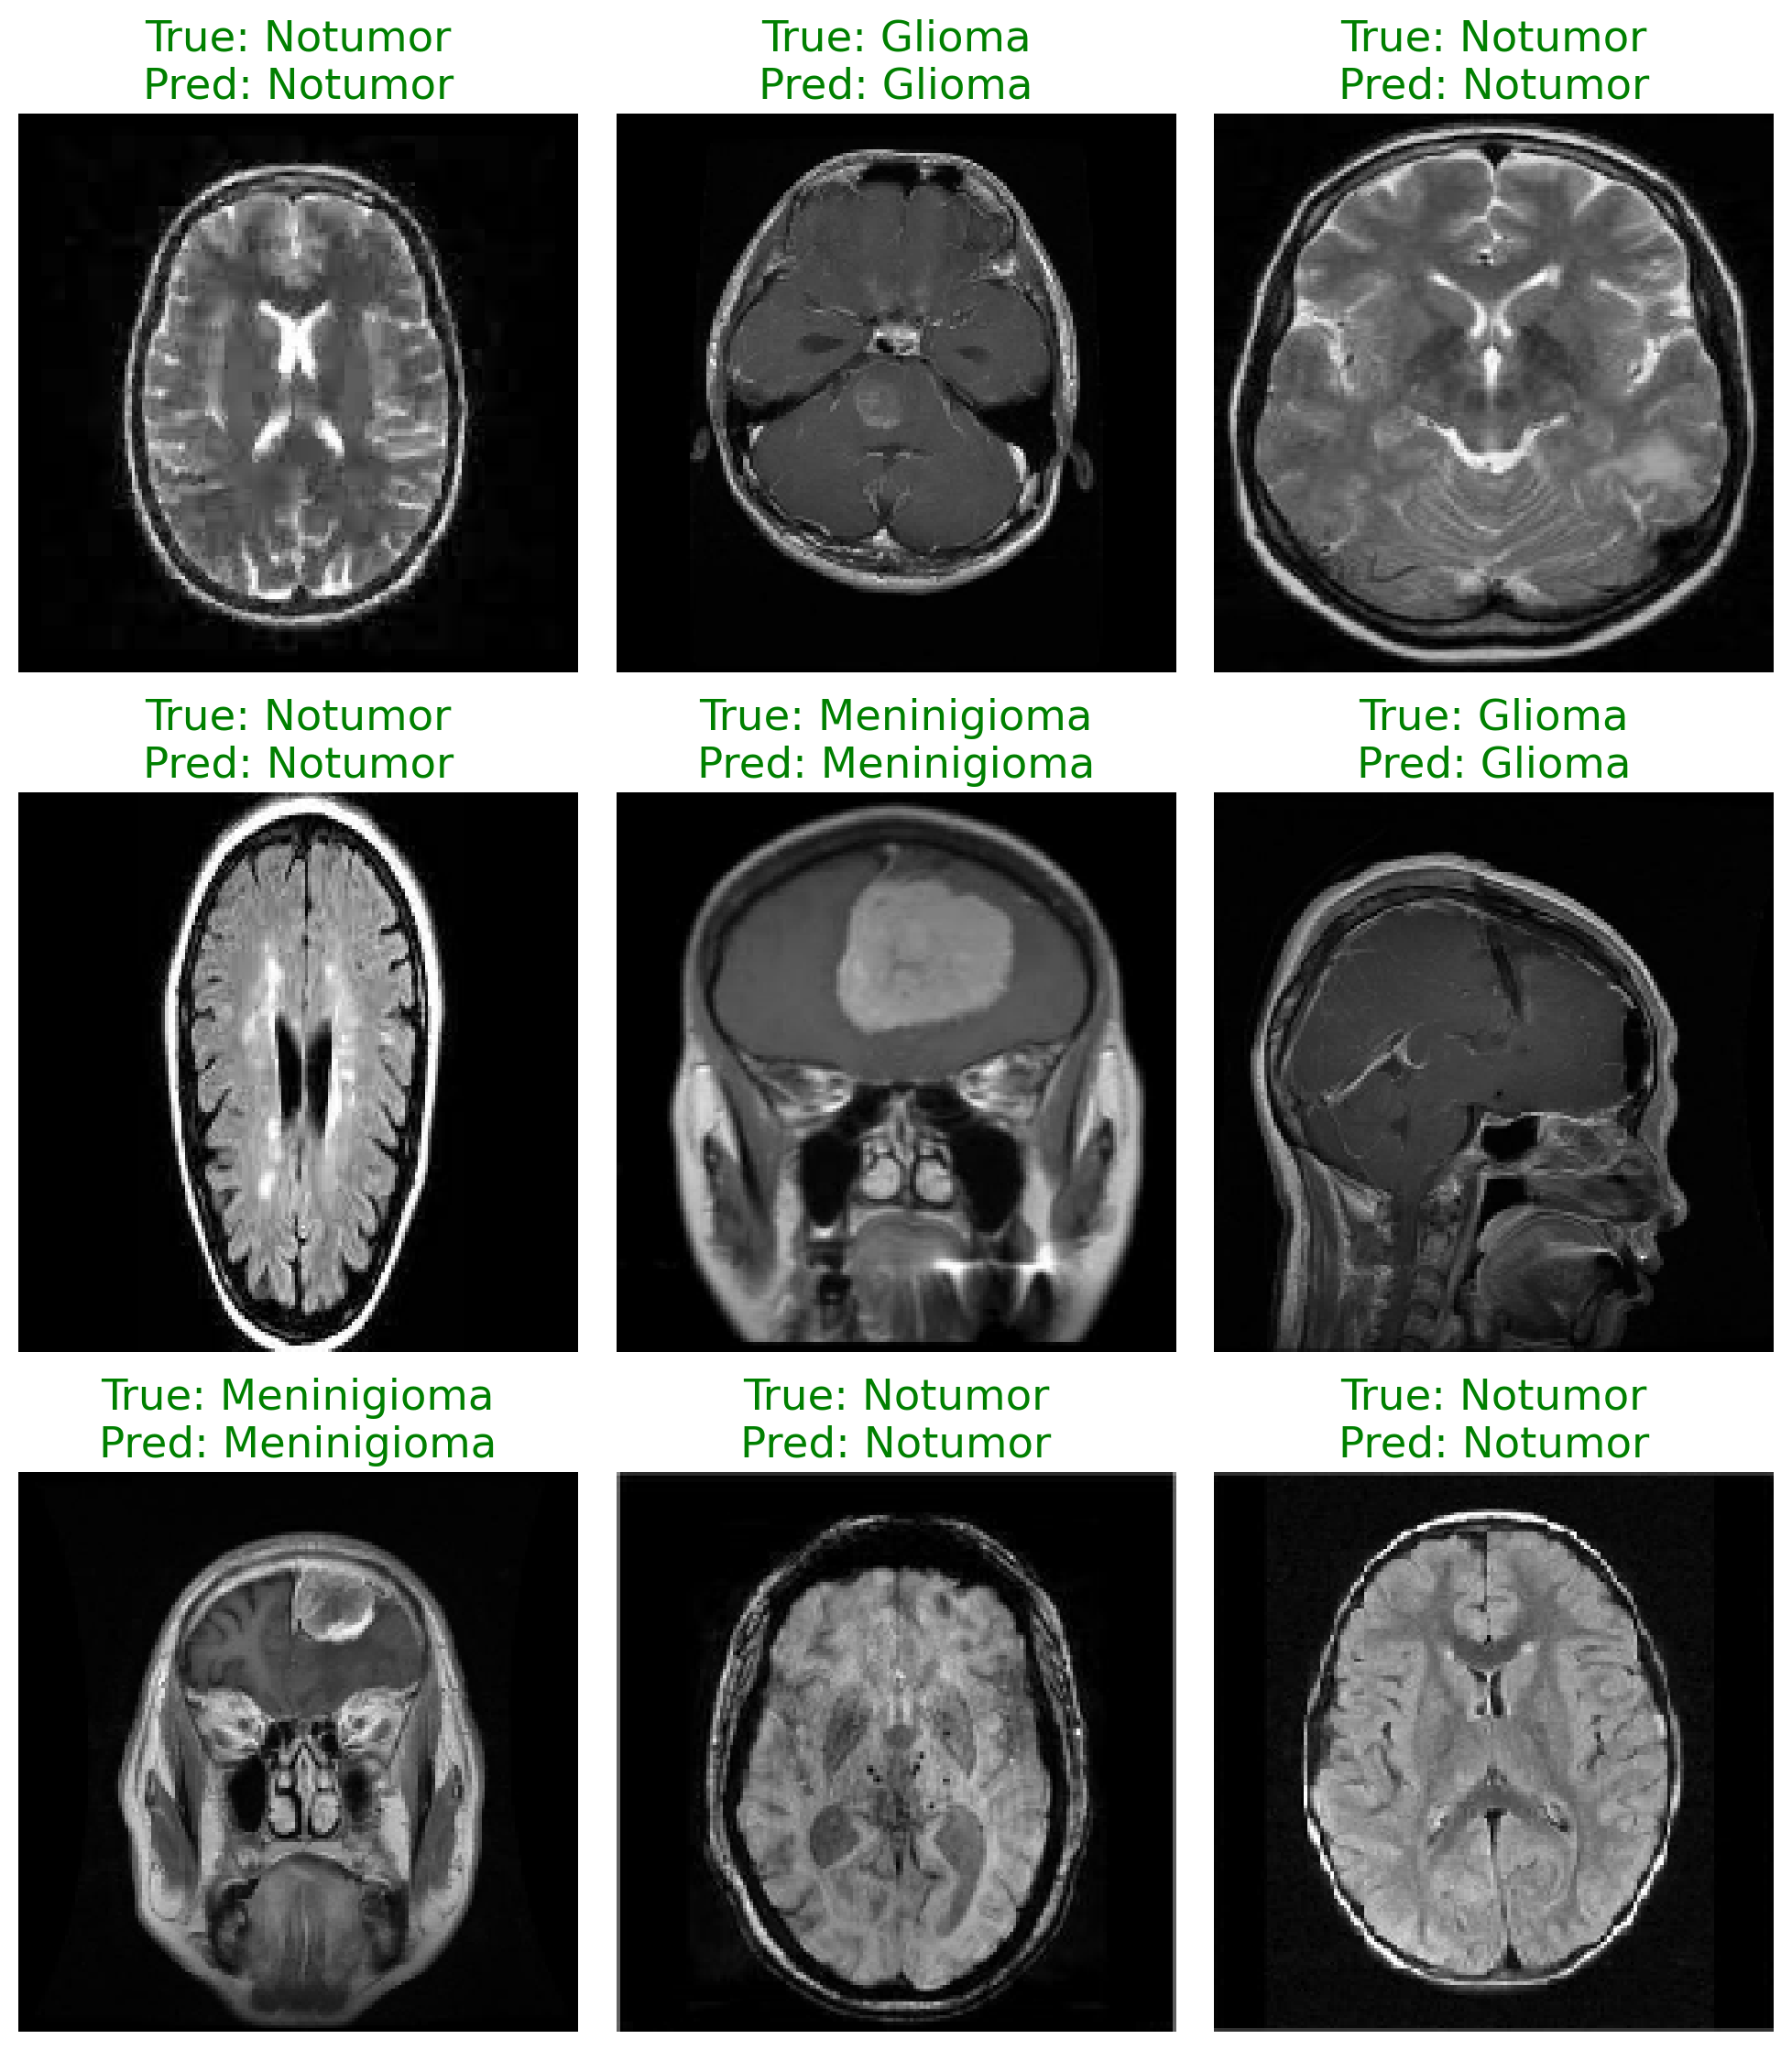

In [63]:
# Plottinng samples with predictions
plot_sample_predictions(model=model,
                        dataset=test_ds_preprocessed, 
                        index_to_class=inv_class_mappings, 
                        num_samples=9,
                        figsize=(10, 11.5))

In [65]:
def plot_misclassified_samples(model, dataset, index_to_class, figsize=(10, 10)):
    misclassified_images = []
    misclassified_labels = []
    misclassified_predictions = []
    
    # Iterate over dataset to collect misclassified images
    for image, true_label in dataset.unbatch():
        image_batch = tf.expand_dims(image, 0)
        predictions = model.predict(image_batch, verbose=False)
        predicted_label = np.argmax(predictions, axis=1)[0]
        true_class_index = np.argmax(true_label.numpy())
        
        if true_class_index != predicted_label:
            misclassified_images.append(image.numpy().squeeze())
            misclassified_labels.append(index_to_class[true_class_index])
            misclassified_predictions.append(index_to_class[predicted_label])

    # Determine number of rows and columns for subplot
    num_misclassified = len(misclassified_images)
    cols = int(np.sqrt(num_misclassified)) + 1
    rows = num_misclassified // cols + (num_misclassified % cols > 0)

    # Plotting misclassified images
    miss_classified_zip = zip(misclassified_images, misclassified_labels, misclassified_predictions)
    plt.figure(figsize=figsize)
    for i, (image, true_label, predicted_label) in enumerate(miss_classified_zip):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"True: {true_label}\nPred: {predicted_label}", color='red')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

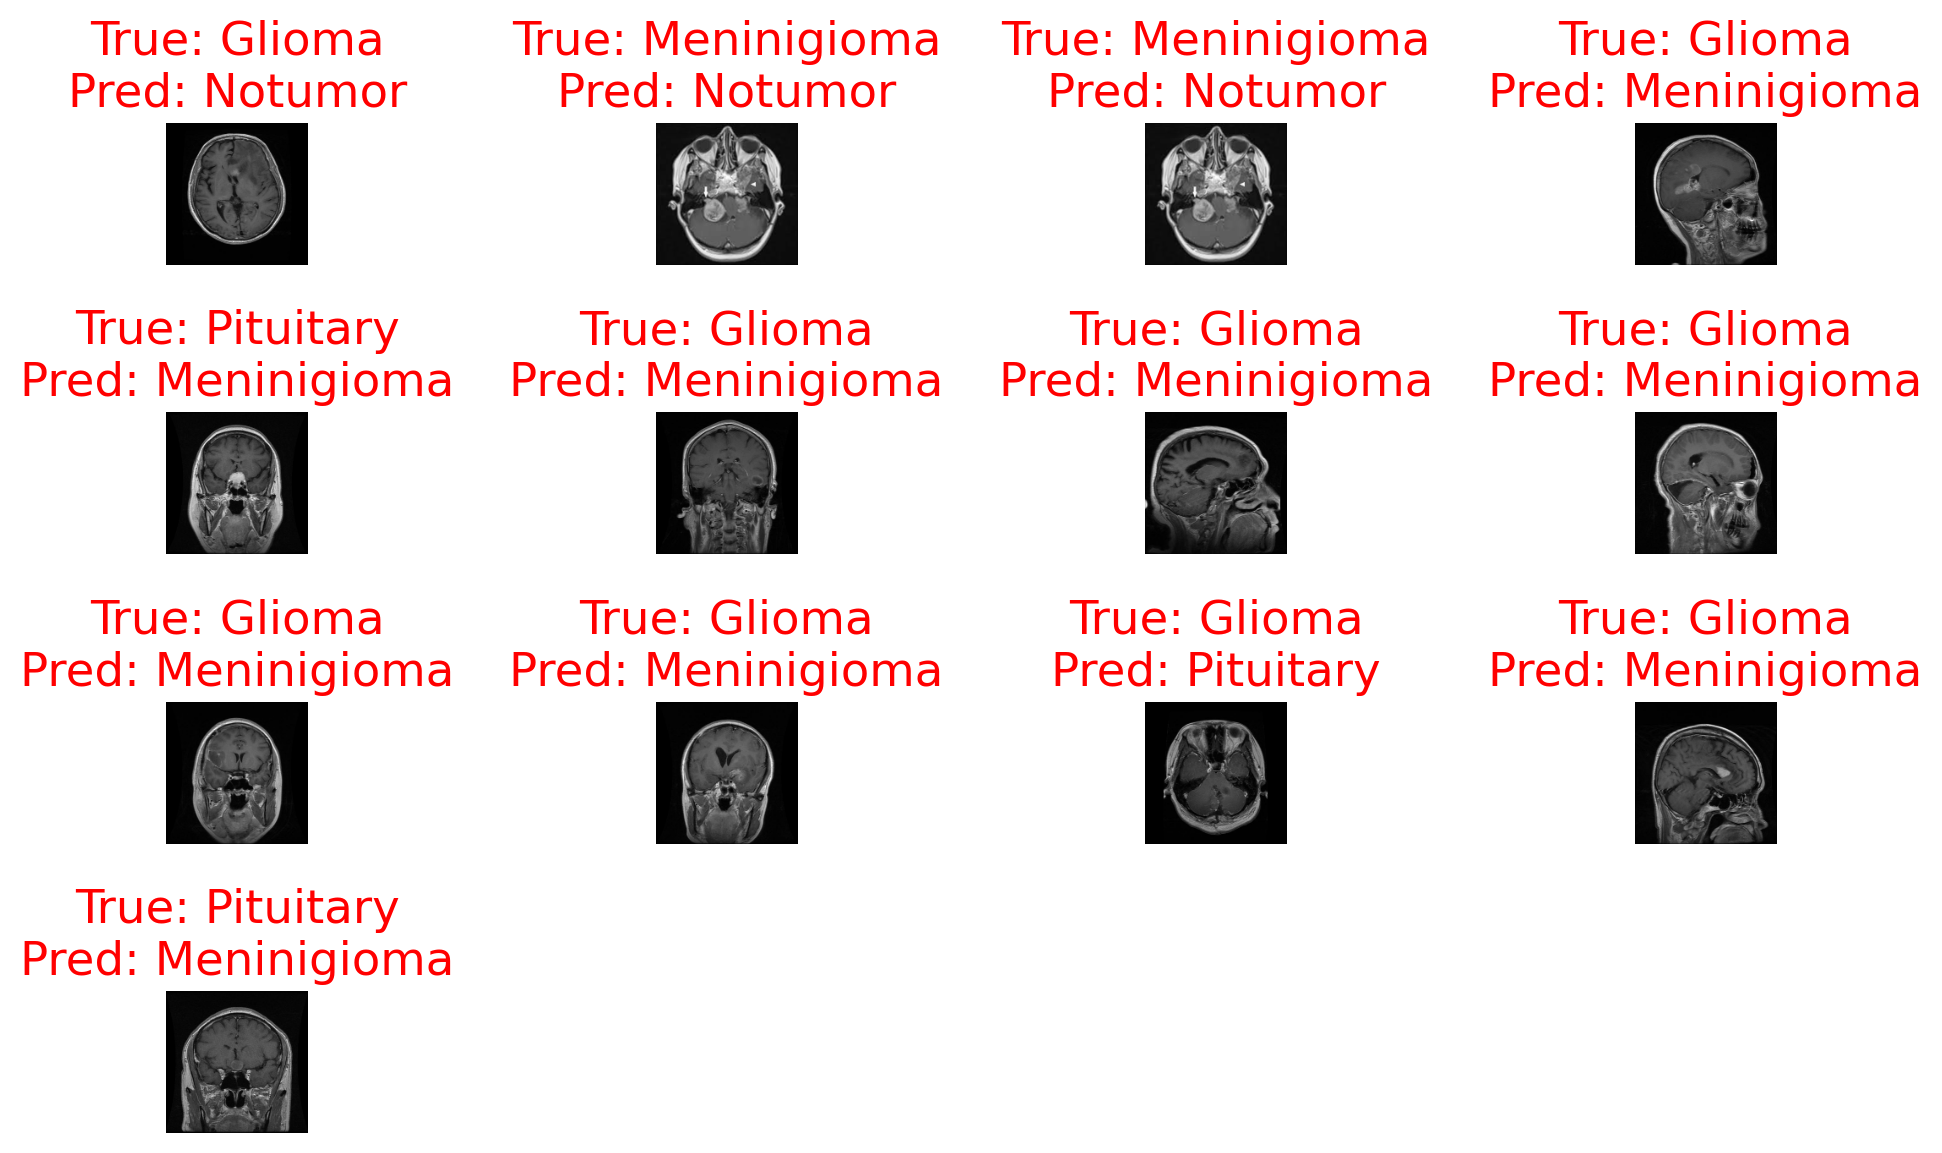

In [66]:
# Plotting misclassified images
plot_misclassified_samples(model=model,
                           dataset=test_ds_preprocessed, 
                           index_to_class=inv_class_mappings,
                           figsize=(10, 6))

In [68]:
# Function to load and preprocess an image
def load_and_preprocess_image(image_path, image_shape=(168, 168)):
    img = image.load_img(image_path, target_size=image_shape, color_mode='grayscale')
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add the batch dimension
    return img_array

# Function to display a row of images with predictions
def display_images_and_predictions(image_paths, predictions, true_labels, figsize=(20, 5)):
    plt.figure(figsize=figsize)
    for i, (image_path, prediction, true_label) in enumerate(zip(image_paths, predictions, true_labels)):
        ax = plt.subplot(1, len(image_paths), i + 1)
        img_array = load_and_preprocess_image(image_path)
        img_array = np.squeeze(img_array)
        plt.imshow(img_array, cmap='gray')
        title_color = 'green' if prediction == true_label else 'red'
        plt.title(f'True Label: {true_label}\nPred: {prediction}', color=title_color)
        plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class Mappings: {'Glioma': 0, 'Meninigioma': 1, 'Notumor': 2, 'Pituitary': 3}

Normal Image Prediction: [0. 0. 1. 0.]
Glioma Image Prediction: [1. 0. 0. 0.]
Meningioma Image Prediction: [0.008 0.992 0.    0.   ]
Pituitary Image Prediction: [0. 0. 0. 1.]


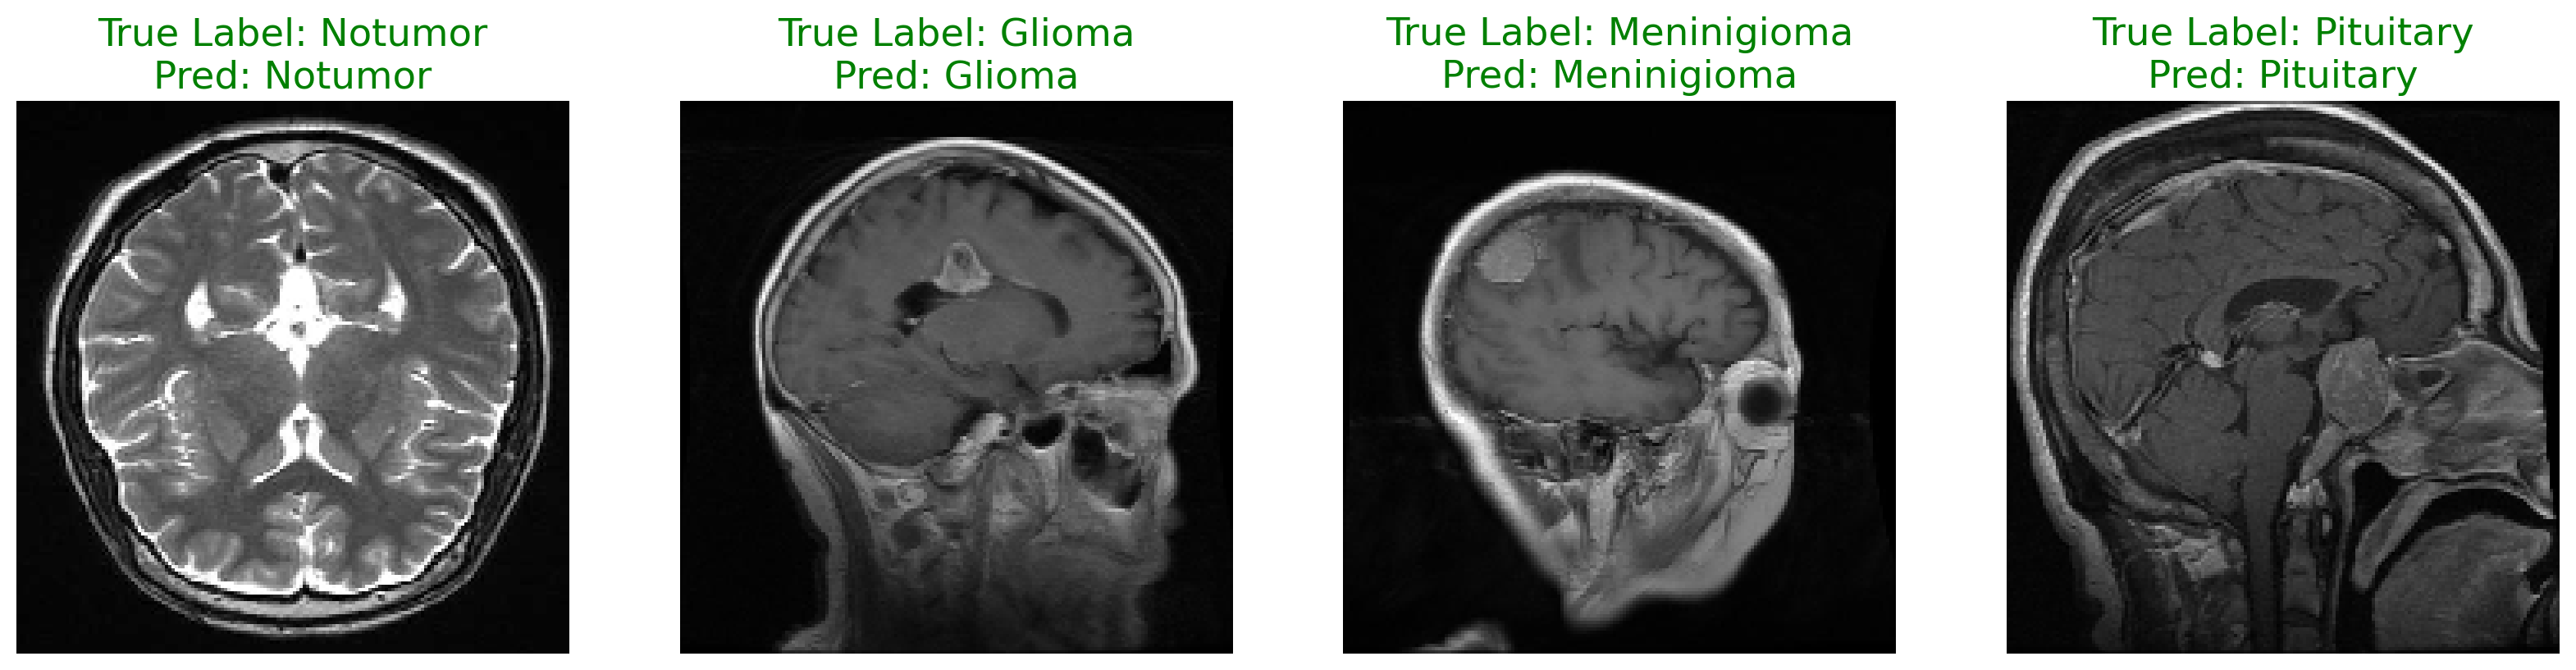

In [69]:
# Load and preprocess the images
normal_image_path = "C:\\Users\\saiva\\Downloads\\archive (3)\\Testing\\notumor\\Te-no_0367.jpg"
glioma_image_path = "C:\\Users\\saiva\\Downloads\\archive (3)\\Testing\\glioma\\Te-gl_0279.jpg"
meningioma_image_path = "C:\\Users\\saiva\\Downloads\\archive (3)\\Testing\\meningioma\\Te-me_0288.jpg"
pituitary_tumor_path = "C:\\Users\\saiva\\Downloads\\archive (3)\\Testing\\pituitary\\Te-pi_0270.jpg"

# Image paths
image_paths = [
    normal_image_path,
    glioma_image_path,
    meningioma_image_path,
    pituitary_tumor_path
]

# True labels for images
true_labels = ['Notumor', 'Glioma', 'Meninigioma', 'Pituitary']

# Load and preprocess images, then make predictions
images = [load_and_preprocess_image(path) for path in image_paths]
predictions = [model.predict(image) for image in images]

# Determine the predicted labels
predicted_labels = [inv_class_mappings[np.argmax(one_hot)] for one_hot in predictions]

# Output the predictions
print(f'Class Mappings: {class_mappings}')
print("\nNormal Image Prediction:", np.round(predictions[0], 3)[0])
print("Glioma Image Prediction:", np.round(predictions[1], 3)[0])
print("Meningioma Image Prediction:", np.round(predictions[2], 3)[0])
print("Pituitary Image Prediction:", np.round(predictions[3], 3)[0])

# Display images with predictions
display_images_and_predictions(image_paths, predicted_labels, true_labels)